
# 수면 설문 데이터 자동화 EDA 노트북

- 변경사항 : 데이터 8:2로 나눠서 CFA용 데이터 분리, hh:mm 타입 값은 평균값과의 상대적 차이로 전환, 카테고리 값도 전부 연속값 취급하여 요인분석에 바로 포함

이 노트북은 **변수 메타데이터(범주형/연속형/설명) 엑셀**을 활용해 다음을 자동으로 수행합니다.
1. 데이터/메타데이터 로드 및 타입 변환
2. 기술통계 요약 (범주형 vs 연속형)
3. 자동 시각화 (히스토그램, 카운트 플롯, 박스플롯)
4. 기본 집단 비교 (교대 vs 비교대, 성별)
5. 상관 히트맵 및 (선택) 요인분석(EFA), 카이제곱 검정

> **사용 전 준비**  
> - 설문 데이터 파일 경로 (예: `sleep_survey.xlsx`)  
> - 변수 메타데이터 파일 경로 (예: `variables_meta.xlsx`)  
> - 메타 파일에는 최소한 다음 컬럼이 있어야 합니다: `변수명`, `범주형`, `연속형`, `타입`, `변수설명`


근데 이제 여기선 범주별 EFA 돌려서 1factor, 혹은 더 많은 축으로 돌린 뒤 '설명력' 을 확인해볼 것

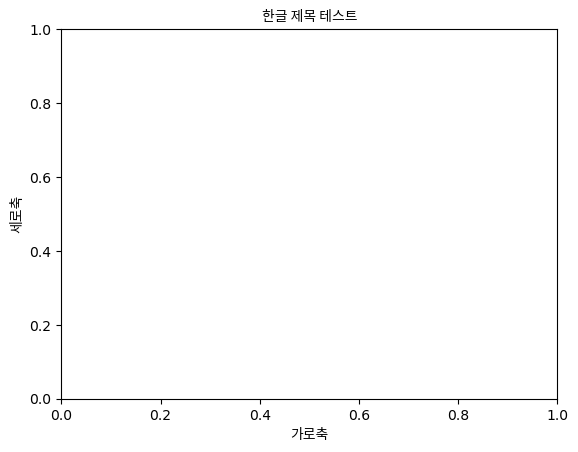

In [1]:
# 폰트 설정

from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager as fm
from matplotlib import rcParams

fp = FontProperties(fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")

plt.title("한글 제목 테스트", fontproperties=fp)
plt.xlabel("가로축", fontproperties=fp)
plt.ylabel("세로축", fontproperties=fp)
plt.show()

fp = fm.FontProperties(fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")
rcParams['font.family'] = fp.get_name()   # 파일에서 읽은 실제 이름 등록
rcParams['axes.unicode_minus'] = False

In [2]:

# ==== 경로 설정 ====
# DATA_FILE = "/home/hschoi/data/leehyunwon/SleepHi/ver2/sleephi_ver2_data_2018_2nd.xlsx"         # 설문 데이터(.xlsx) # 날짜 형식 문제 있으면 _edited 사용할 것으로 예상했으나 코드 문제로 보임
# META_FILE = "/home/hschoi/data/leehyunwon/SleepHi/ver2/sleephi_ver2_variable_2018_2nd.xlsx"       # 변수 메타데이터(.xlsx)

# 이전에 받은 데이터용
DATA_FILE = "/home/hschoi/data/leehyunwon/SleepHi/Sleep Hi_KSHS_2nd_data_250811.xlsx"         # 설문 데이터(.xlsx) # 날짜 형식 문제 있으면 _edited 사용할 것으로 예상했으나 코드 문제로 보임
META_FILE = "/home/hschoi/data/leehyunwon/SleepHi/Sleep Hi_Variable_250811.xlsx"       # 변수 메타데이터(.xlsx)

# OUT_DIR = "eda_results"                 # 결과 이미지 저장 폴더

# ==== 라이브러리 ====
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt
import re
from sklearn.impute import SimpleImputer
from pandas.api.types import (
    is_datetime64_any_dtype, is_timedelta64_dtype,
    is_object_dtype, is_numeric_dtype
)
import re
import numpy as np
import pandas as pd
import datetime as dt
from pandas.api.types import (
    is_datetime64_any_dtype, is_timedelta64_dtype,
    is_object_dtype, is_numeric_dtype
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import logsumexp
from stepmix.stepmix import StepMix
from sklearn.model_selection import train_test_split
from itertools import zip_longest

# 선택 라이브러리 (미설치 시 주석 처리 가능)
try:
    from factor_analyzer import FactorAnalyzer
    HAS_FACTOR = True
except Exception:
    HAS_FACTOR = False
    print("[알림] factor_analyzer가 설치되어 있지 않습니다. (pip install factor-analyzer)")

# # 한글 폰트 설정 (환경에 따라 주석 필요)
# plt.rcParams['font.family'] = 'Noto Sans CJK KR'  # 환경에 맞게 변경하세요
# plt.rcParams['axes.unicode_minus'] = False

# os.makedirs(OUT_DIR, exist_ok=True)
print("환경 준비 완료.")


환경 준비 완료.


In [3]:

# ==== 데이터/메타데이터 로드 ====
df = pd.read_excel(DATA_FILE)
meta = pd.read_excel(META_FILE)

print("데이터 크기:", df.shape)
print("컬럼 예시:", df.columns[:10].tolist())

# 메타 필수 컬럼 체크
required_cols = {"변수명", "범주형", "연속형"}
missing_meta_cols = required_cols - set(meta.columns)
if missing_meta_cols:
    raise ValueError(f"메타데이터에 필요한 컬럼이 없습니다: {missing_meta_cols}")

# 범주/연속 변수 리스트
categorical_vars = meta.loc[meta["범주형"] == 1, "변수명"].dropna().astype(str).tolist()
continuous_vars = meta.loc[meta["연속형"] == 1, "변수명"].dropna().astype(str).tolist()

# 실제 df에 존재하는 컬럼만 사용
categorical_vars = [c for c in categorical_vars if c in df.columns]
continuous_vars = [c for c in continuous_vars if c in df.columns]

print("범주형 변수 개수:", len(categorical_vars))
print("연속형 변수 개수:", len(continuous_vars))


데이터 크기: (2501, 97)
컬럼 예시: ['ID', 'SW', 'sex', 'age', 'age_group', 'Q59_1_w', 'Q59_1_f', 'D3_1_ht', 'D3_2_wt', 'BMI']
범주형 변수 개수: 21
연속형 변수 개수: 75


In [4]:
# 누락변수 있으면 확인 후 제거 (ID는 원래 제외하는게 맞음)
print(set(df.columns) - set(categorical_vars + continuous_vars))

df.drop(set(df.columns) - set(categorical_vars + continuous_vars), axis=1, inplace=True)

{'ID'}


In [5]:
# 특정 열의 값 하나 출력
print("예시 값:", df["MCTQ_GUa"].values[:5])
print("예시 값:", df["MCTQ_MSF"].values[:5])
print("예시 값:", df["MSF_mismatch_pristine"].values[:5])
print("예시 값:", df["MCTQ_MBF"].values[:5])
# print("예시 값:", df["MCTQ_SOf_c"].values[:5]) # ver2 변수에선 없음
print("예시 값:", df["MCTQ_SOa_c"].values[:5])
# print("예시 값:", df["MCTQ_SOw_c"].values[:5]) # ver2 변수에선 없음
# print("예시 값:", df["MCTQ_TFPw"].values[:5]) # ver2 변수에선 없음


# print("예시 값:", df_copy["MCTQ_GUa"].values[:5])
# print("예시 값:", df_copy["MCTQ_MSF"].values[:5])
# print("예시 값:", df_copy["MSF_mismatch_pristine"].values[:5])
# print("예시 값:", df_copy["MCTQ_MBF"].values[:5])
# print("예시 값:", df_copy["MCTQ_SOf_c"].values[:5])
# print("예시 값:", df_copy["MCTQ_SOa_c"].values[:5])
# print("예시 값:", df_copy["MCTQ_SOw_c"].values[:5])
# print("예시 값:", df_copy["MCTQ_TFPw"].values[:5])

예시 값: [datetime.time(10, 30) datetime.time(9, 4, 17, 143000)
 datetime.time(8, 22, 8, 571000) datetime.time(9, 55, 51, 429000)
 datetime.time(8, 18, 34, 286000)]
예시 값: [datetime.time(5, 40) datetime.time(5, 5) datetime.time(4, 32, 30)
 datetime.time(8, 20) datetime.time(4, 20)]
예시 값: [datetime.time(2, 10) datetime.time(0, 35) datetime.time(0, 2, 30)
 datetime.time(2, 50) datetime.time(0, 20)]
예시 값: [datetime.datetime(1900, 1, 1, 5, 45) datetime.datetime(1900, 1, 1, 4, 50)
 datetime.datetime(1900, 1, 1, 4, 32, 30)
 datetime.datetime(1900, 1, 1, 8, 1, 30)
 datetime.datetime(1900, 1, 1, 4, 20)]
예시 값: [datetime.datetime(1900, 1, 1, 1, 28, 34, 286000)
 datetime.datetime(1900, 1, 1, 0, 4, 17, 143000)
 datetime.datetime(1900, 1, 1, 0, 5)
 datetime.datetime(1900, 1, 1, 3, 25, 42, 857000)
 datetime.datetime(1900, 1, 1, 0, 10)]


# 결측치 관리 : 평균or0처리, 아니면 결측치 전부 제거(일단 후자로 진행)

In [6]:
# # 결측치 평균값으로 두고 아예 없으면 0으로 두기, 하고 나서 위에 결측치 플롯 다시 해보기 (카테고리 값은 제외되었으니 위의 플롯에 카테고리만 보일 것)

# # Get a list of only the numeric columns
# numeric_cols = df.select_dtypes(include=np.number).columns

# # Loop through the numeric columns
# for column in numeric_cols:
#     # Calculate the mean of the column, ignoring NaNs
#     mean_value = df[column].mean()

#     # If the mean is NaN (the entire column is null), set it to 0
#     if pd.isna(mean_value):
#         mean_value = 0

#     # Fill the null values in the column with the calculated mean
#     df[column].fillna(mean_value, inplace=True)

In [7]:
# 이번엔 다른 작업, 하나라도 NaN이 있으면 해당 행 제거
df_clean = df.dropna()

print("원래 행 개수:", len(df))
print("결측치 제거 후 행 개수:", len(df_clean))


df = df_clean.copy()

원래 행 개수: 2501
결측치 제거 후 행 개수: 2363


# 시간 값 변환

In [8]:
# 숫자 duration(ns/us/ms/s/h/min)을 원소별 '분'으로 환산
def _numeric_duration_to_minutes_elwise(arr: pd.Series) -> pd.Series:
    v = pd.to_numeric(arr, errors="coerce").astype("float").to_numpy()
    out = np.full_like(v, np.nan, dtype="float64")
    a = np.abs(v)

    ns = (a >= 1e11)                             # 예: 1.8e12 ≈ 30분(ns)
    us = (~ns) & (a >= 1e8)                      # μs
    ms = (~ns) & (~us) & (a >= 1e6)              # ms
    sec= (~ns) & (~us) & (~ms) & (a >= 60)       # s
    minute = (~ns) & (~us) & (~ms) & (~sec) & (a > 0) & (a <= 24*60)
    hour   = (~ns) & (~us) & (~ms) & (~sec) & (~minute) & (a > 0)

    out[ns]     = v[ns]    / (1e9 * 60.0)
    out[us]     = v[us]    / (1e6 * 60.0)
    out[ms]     = v[ms]    / (1e3 * 60.0)
    out[sec]    = v[sec]   / 60.0
    out[minute] = v[minute]
    out[hour]   = v[hour]  * 60.0

    # 0은 유효값
    out[np.isfinite(v) & (v == 0)] = 0.0
    return pd.Series(out, index=arr.index)

_hhmm_pat = re.compile(r"^(\d{1,2}):(\d{2})(?::(\d{2})(?:\.(\d+)?)?)?$")

def _safe_to_minutes_scalar(x):
    """단일 값 x를 '분(float)'으로. 해석 불가 시 np.nan (→ 열 전체 변환 스킵 트리거)."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan

    # python datetime/time
    if isinstance(x, dt.time):
        return x.hour*60 + x.minute + x.second/60.0
    if isinstance(x, dt.datetime):
        return x.hour*60 + x.minute + x.second/60.0

    # pandas 계열
    if isinstance(x, pd.Timestamp):
        return x.hour*60 + x.minute + x.second/60.0
    if isinstance(x, pd.Timedelta):
        return x.total_seconds()/60.0
    if isinstance(x, np.datetime64):
        try:
            ts = pd.to_datetime(x)
            return ts.hour*60 + ts.minute + ts.second/60.0
        except Exception:
            return np.nan

    # 숫자: duration 단위 추정
    if isinstance(x, (int, float, np.integer, np.floating)):
        if np.isnan(x): 
            return np.nan
        v = float(x); av = abs(v)
        if av >= 1e11: return v/(1e9*60.0) # ns
        if av >= 1e8:  return v/(1e6*60.0) # μs
        if av >= 1e6:  return v/(1e3*60.0) # ms
        if av >= 60:   return v/60.0       # s
        if 0 <= v <= 24*60: return v       # 분
        return v*60.0                       # 시간

    # 문자열: timedelta → datetime → HH:MM(:SS) → 숫자 문자열
    if isinstance(x, str):
        sx = x.strip()
        if not sx:
            return np.nan
        try:
            td = pd.to_timedelta(sx)
            if isinstance(td, pd.Timedelta) or hasattr(td, "components"):
                return float(td.total_seconds())/60.0
        except Exception:
            pass
        try:
            ts = pd.to_datetime(sx)
            if isinstance(ts, pd.Timestamp):
                return ts.hour*60 + ts.minute + ts.second/60.0
        except Exception:
            pass
        m = _hhmm_pat.match(sx)
        if m:
            h, m_, s_ = int(m.group(1)), int(m.group(2)), int(m.group(3) or 0)
            return h*60 + m_ + s_/60.0
        try:
            fv = float(sx.replace(",", ""))
            return _safe_to_minutes_scalar(fv)
        except Exception:
            return np.nan

    return np.nan

def series_to_minutes_strict(s: pd.Series) -> (pd.Series, pd.Series):
    """
    시리즈 전체를 '분'으로 변환.
    - dtype별 최적 경로 사용, object 혼합은 원소별 안전 파서 사용
    - 반환: (minutes_series, ok_mask) ; ok_mask=False가 하나라도 있으면 열 전체 변환 스킵
    """
    if is_timedelta64_dtype(s):
        out = (s.dt.total_seconds() / 60.0).astype("float")
        ok = s.notna() | (out == 0.0)
        return out, ok

    if is_datetime64_any_dtype(s):
        out = (s.dt.hour*60 + s.dt.minute + s.dt.second/60.0).astype("float")
        ok = s.notna() | (out == 0.0)
        return out, ok

    if is_numeric_dtype(s):
        out = _numeric_duration_to_minutes_elwise(s).astype("float")
        ok = out.notna() | (out == 0.0)
        return out, ok

    # object 혼합형: 안전 파서로 원소별 처리
    out = s.map(_safe_to_minutes_scalar).astype("float")
    ok  = out.notna() | (out == 0.0)
    return out, ok

def looks_time_like_series(s: pd.Series, sample_n: int = 200) -> bool:
    """연속형 후보 중 '시간/지속시간'으로 보이는지 휴리스틱 판정."""
    if is_datetime64_any_dtype(s) or is_timedelta64_dtype(s):
        return True
    if is_object_dtype(s):
        smp = s.dropna().astype(str).head(sample_n)
        if smp.empty: 
            return False
        if smp.str.contains(r"\bdays\b|^\s*\d{1,2}:\d{2}(:\d{2}(\.\d+)?)?$|^1900-01-01", regex=True).any():
            return True
        has_dt_like = s.dropna().map(lambda v: isinstance(v, (dt.time, dt.datetime, pd.Timestamp, pd.Timedelta, np.datetime64))).any()
        if has_dt_like:
            return True
    if is_numeric_dtype(s):
        smp = s.dropna().astype(float).abs().head(sample_n)
        if smp.empty:
            return False
        if (smp.ge(1e6).mean() > 0.05) or (smp.between(0, 24*60).mean() > 0.5):
            return True
    return False

def convert_time_columns_inplace_for_efa(df: pd.DataFrame, continuous_vars: list):
    """
    - continuous_vars 중 시간/지속시간으로 보이는 열만 골라 in-place로 분(float)로 변환
    - 한 값이라도 실패하면 그 열은 변환하지 않음(원본 유지)
    - 반환: {'converted': [...], 'skipped': [...], 'issues': DataFrame, 'efa_cols': [...]}
    """
    converted, skipped, issues = [], [], []

    # 시간/지속시간 후보만 선별
    time_like_candidates = [c for c in continuous_vars if c in df.columns and not is_numeric_dtype(df[c]) and looks_time_like_series(df[c])]

    for col in time_like_candidates:
        minutes, ok = series_to_minutes_strict(df[col])
        if ok.all():
            # 원본 열을 '분(float)'로 덮어쓰기
            df[col] = minutes.astype("float")
            converted.append(col)
        else:
            skipped.append(col)
            bad = ~ok
            bad_examples = df.loc[bad, col].astype(str).value_counts().head(10)
            issues.append({
                "column": col,
                "n_total": int(len(df)),
                "n_failed": int(bad.sum()),
                "examples": "; ".join([f"{k} x{v}" for k, v in bad_examples.items()])
            })

    # EFA에 실제로 투입 가능한 연속형 열(숫자형만)
    efa_cols = [c for c in continuous_vars if c in df.columns and is_numeric_dtype(df[c])]

    issues_df = pd.DataFrame(issues).sort_values("n_failed", ascending=False) if issues else pd.DataFrame(columns=["column","n_total","n_failed","examples"])

    return {
        "converted": converted,
        "skipped": skipped,
        "issues": issues_df,
        "efa_cols": efa_cols
    }

# ===== 실행부 =====
# continuous_vars는 질문에서 이미 만들어져 있다고 가정
report = convert_time_columns_inplace_for_efa(df, continuous_vars)

print("[변환 완료 요약]")
print("  변환 성공 열 수:", len(report["converted"]))
if report["converted"]:
    print("   └", report["converted"])

print("  변환 스킵 열 수:", len(report["skipped"]))
if report["skipped"]:
    print("   └", report["skipped"])
    print("\n[스킵 사유(문제 값 예시)]")
    print(report["issues"].to_string(index=False))

# EFA 투입 열 목록 (숫자형만)
efa_cols = report["efa_cols"]
print("\n[EFA 열 개수]:", len(efa_cols))
# 이제 바로 EFA:
# X_efa = df[efa_cols].copy()
# print("EFA 입력 크기:", X_efa.shape)

[변환 완료 요약]
  변환 성공 열 수: 29
   └ ['MCTQ_BTw_c', 'MCTQ_BTf_c', 'MCTQ_BTa_c', 'MCTQ_GUw', 'MCTQ_GUf', 'MCTQ_GUa', 'MCTQ_MBW', 'MCTQ_MBF', 'MCTQ_Sprepw_c', 'MCTQ_Sprepf_c', 'MCTQ_Sprepa_c', 'MCTQ_TFPw', 'MCTQ_TFPf', 'MCTQ_TFPa', 'MCTQ_SOw_c', 'MCTQ_SOf_c', 'MCTQ_SOa_c', 'MCTQ_SEw', 'MCTQ_SEf', 'MCTQ_SEa', 'MCTQ_MSW', 'MCTQ_MSF', 'Pristine_SO_c', 'Pristine_SE', 'Pristine_MS', 'SO_mismatch_pristine', 'SE_mismatch_pristine', 'MSW_mismatch_pristine', 'MSF_mismatch_pristine']
  변환 스킵 열 수: 0

[EFA 열 개수]: 75


/tmp/ipykernel_441125/2823622462.py:125: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if smp.str.contains(r"\bdays\b|^\s*\d{1,2}:\d{2}(:\d{2}(\.\d+)?)?$|^1900-01-01", regex=True).any():
/tmp/ipykernel_441125/2823622462.py:125: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if smp.str.contains(r"\bdays\b|^\s*\d{1,2}:\d{2}(:\d{2}(\.\d+)?)?$|^1900-01-01", regex=True).any():
/tmp/ipykernel_441125/2823622462.py:125: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if smp.str.contains(r"\bdays\b|^\s*\d{1,2}:\d{2}(:\d{2}(\.\d+)?)?$|^1900-01-01", regex=True).any():
/tmp/ipykernel_441125/2823622462.py:125: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract

# Ver2 추가 : hh:mm 타입 값은 각 변수 평균값과의 상대적 값으로 전부 변경

In [9]:
# ---------------------------------------
# hh:mm 타입 변수의 평균 기준 상대값 변환
# ---------------------------------------
def apply_relative_to_mean(df, meta):
    # (1) hh:mm 타입 변수 목록
    cols = meta.loc[meta["타입"].astype(str).str.lower().str.strip() == "hh:mm", "변수명"].dropna().astype(str)
    cols = [c for c in cols if c in df.columns]
    if not cols:
        print("⚠️ 변환 대상(hh:mm 타입) 변수가 없습니다.")
        return df

    df_out = df.copy()
    print(f"\n[상대적 차이 변환 결과 요약] (단위: 분)\n")

    for col in cols:
        s = df_out[col].astype(float)
        mean_val = s.mean(skipna=True)
        df_out[col] = s - mean_val  # 평균 대비 상대값으로 치환

        # 간단한 출력 (원본 평균, 샘플 3개 비교)
        sample_idx = s.dropna().index[:3]
        sample_vals = s.loc[sample_idx].tolist()
        rel_vals = df_out.loc[sample_idx, col].tolist()

        print(f"📘 변수명: {col}")
        print(f"  원본 평균: {mean_val:.2f}분")
        for i, idx in enumerate(sample_idx):
            print(f"   - 샘플{i+1}: 원본={sample_vals[i]:.2f}, 상대={rel_vals[i]:+.2f}")
        print()

    return df_out


# ---------------------------------------
# 실행 예시
# ---------------------------------------
df = apply_relative_to_mean(df, meta)



[상대적 차이 변환 결과 요약] (단위: 분)

📘 변수명: MCTQ_BTw_c
  원본 평균: 1006.97분
   - 샘플1: 원본=150.00, 상대=-856.97
   - 샘플2: 원본=0.00, 상대=-1006.97
   - 샘플3: 원본=60.00, 상대=-946.97

📘 변수명: MCTQ_BTf_c
  원본 평균: 832.77분
   - 샘플1: 원본=180.00, 상대=-652.77
   - 샘플2: 원본=0.00, 상대=-832.77
   - 샘플3: 원본=60.00, 상대=-772.77

📘 변수명: MCTQ_BTa_c
  원본 평균: 1013.54분
   - 샘플1: 원본=158.57, 상대=-854.97
   - 샘플2: 원본=0.00, 상대=-1013.54
   - 샘플3: 원본=60.00, 상대=-953.54

📘 변수명: MCTQ_GUw
  원본 평균: 408.14분
   - 샘플1: 원본=521.00, 상대=+112.86
   - 샘플2: 원본=490.00, 상대=+81.86
   - 샘플3: 원본=500.00, 상대=+91.86

📘 변수명: MCTQ_GUf
  원본 평균: 484.43분
   - 샘플1: 원본=783.00, 상대=+298.57
   - 샘플2: 원본=520.00, 상대=+35.57
   - 샘플3: 원본=540.00, 상대=+55.57

📘 변수명: MCTQ_GUa
  원본 평균: 426.29분
   - 샘플1: 원본=595.85, 상대=+169.56
   - 샘플2: 원본=498.57, 상대=+72.28
   - 샘플3: 원본=511.42, 상대=+85.13

📘 변수명: MCTQ_MBW
  원본 평균: 180.74분
   - 샘플1: 원본=335.50, 상대=+154.76
   - 샘플2: 원본=245.00, 상대=+64.26
   - 샘플3: 원본=280.00, 상대=+99.26

📘 변수명: MCTQ_MBF
  원본 평균: 228.06분
   - 샘플1: 원본=481.50, 상대=+253.44
   -

# Ver2 추가 : 변환 작업 다 끝났으면 z-score 표준화 통해 스케일 영향 제거 (EFA때는 큰 영향 없지만 CFA 시 필수적이라 함)

In [10]:
# 수치형 열 전부 포함 (즉, dtype이 number면 모두 표준화)
num_cols = df.select_dtypes(include=['number']).columns

print(len(num_cols))

# 수치형 열 전부 표준화 (원본 df 자체에 덮어쓰기)
df[num_cols] = (df[num_cols] - df[num_cols].mean()) / df[num_cols].std(ddof=0)

96


# Ver2 추가 : 데이터셋 5:5 비율로 랜덤시드 넣어서 분리

In [11]:
# 재현성 확보용 랜덤 시드
RANDOM_SEED = 42

# 8:2로 나누기
df_EFA, df_CFA = train_test_split(df, test_size=0.5, random_state=RANDOM_SEED)

print("✅ 데이터 분할 완료")
print(f" - EFA용 데이터: {df_EFA.shape}")
print(f" - CFA용 데이터: {df_CFA.shape}")


print("예시 값:", df_EFA["MCTQ_GUa"].values[:5])
print("예시 값:", df_EFA["MCTQ_MSF"].values[:5])
print("예시 값:", df_EFA["MSF_mismatch_pristine"].values[:5])
print("예시 값:", df_EFA["MCTQ_MBF"].values[:5])

print("예시 값:", df_CFA["MCTQ_GUa"].values[:5])
print("예시 값:", df_CFA["MCTQ_MSF"].values[:5])
print("예시 값:", df_CFA["MSF_mismatch_pristine"].values[:5])
print("예시 값:", df_CFA["MCTQ_MBF"].values[:5])

✅ 데이터 분할 완료
 - EFA용 데이터: (1181, 96)
 - CFA용 데이터: (1182, 96)
예시 값: [-0.73228172  0.81947845  0.4125127  -0.862372    0.37348562]
예시 값: [-0.82124815  0.19851767 -0.0502057  -1.24407788 -0.19943972]
예시 값: [-0.81906622 -0.77939342  0.09340821 -0.54135661 -0.77939342]
예시 값: [-0.84275058  0.29867342 -0.08180125 -1.09640035 -0.15789618]
예시 값: [-2.29336502 -0.23056689 -0.26785944 -0.78822054  0.43853076]
예시 값: [-2.28871604  0.19851767 -0.2491844  -0.64714179 -0.39841842]
예시 값: [-0.77939342  1.04555544 -0.38266541 -0.065283    0.33144502]
예시 값: [-2.26318932  0.12111857 -0.20862614 -0.74129067 -0.43691093]


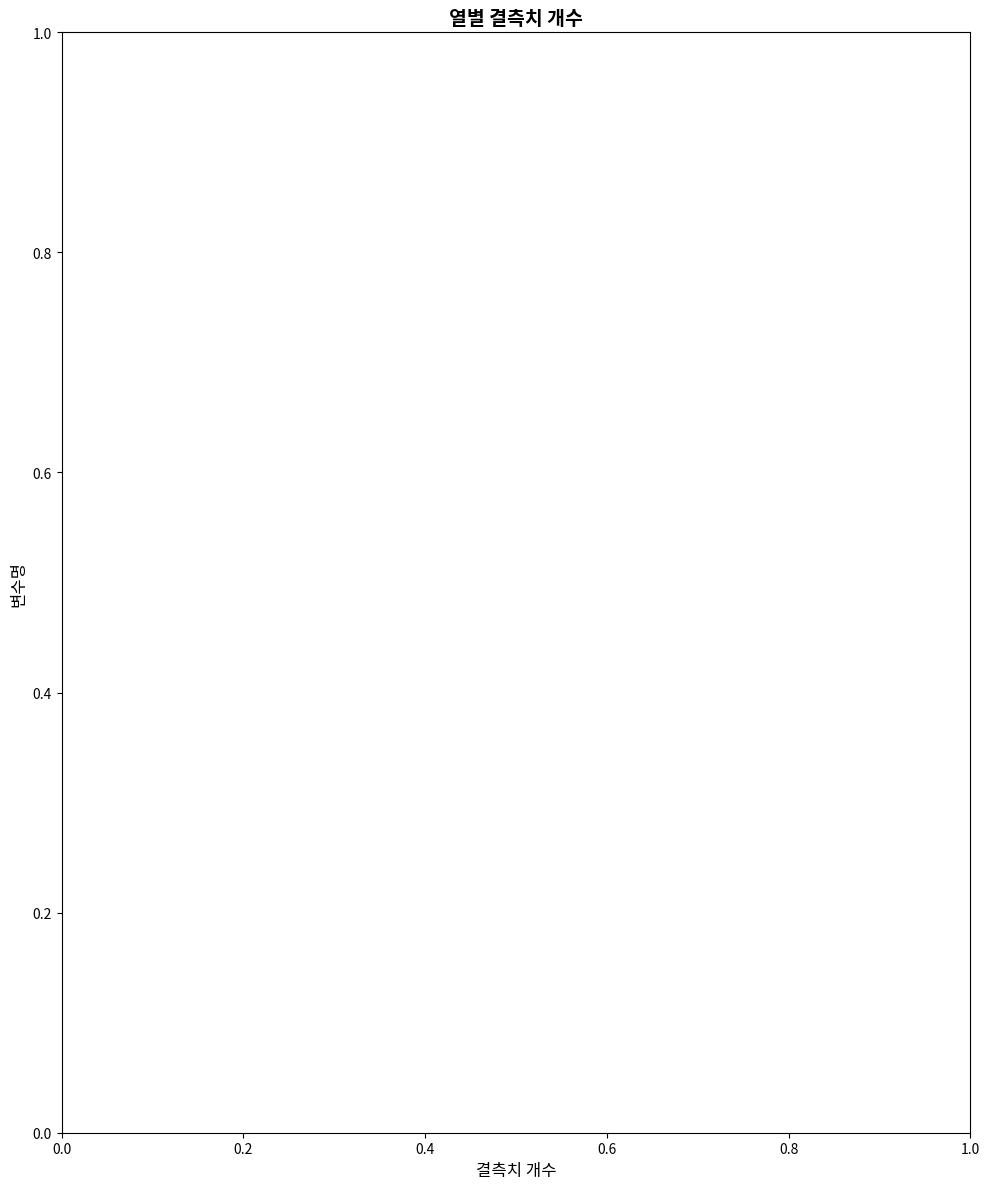

In [12]:
# 1. 열별 결측치 개수 계산
missing_counts = df.isnull().sum()

# 2. 결측치 있는 열만 추림 & 내림차순 정렬
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

# 3. Barplot 시각화
plt.figure(figsize=(10, 12))
sns.barplot(x=missing_counts.values, y=missing_counts.index, palette="Blues_r")
plt.xlabel("결측치 개수", fontsize=12)
plt.ylabel("변수명", fontsize=12)
plt.title("열별 결측치 개수", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

# 임시 : 카테고리값까지 넣다 보니 나이와 나이 그룹이 같이 들어감, 이것도 제거
# (BMI는 일단 주석으로만 남기기)

In [13]:
# df_EFA = df_EFA.drop(columns=['D3_1_ht', 'D3_2_wt', 'BMI', 'age_group'])
# df_CFA = df_CFA.drop(columns=['D3_1_ht', 'D3_2_wt', 'BMI', 'age_group'])

df_EFA = df_EFA.drop(columns=['age_group'])
df_CFA = df_CFA.drop(columns=['age_group'])

print(df_EFA.shape)

(1181, 95)


# 분산이 작은 변수는 요인분석에 방해됨 : 분산이 1e-5 이하인 변수 제거

In [14]:
var_threshold = 1e-5
low_var_cols = df.var()[df.var() <= var_threshold].index.tolist()
print("[제거] 분산이 너무 작은 열:", low_var_cols)

df = df.drop(columns=low_var_cols)


[제거] 분산이 너무 작은 열: []


# EFA 시작

[EFA] 고유값(Eigenvalues): [ 1.52881e+01  1.09006e+01  8.24030e+00  4.67170e+00  4.03310e+00
  3.39310e+00  3.23830e+00  2.93270e+00  2.43190e+00  2.24100e+00
  2.08810e+00  1.83000e+00  1.79320e+00  1.64970e+00  1.59790e+00
  1.48110e+00  1.42060e+00  1.35200e+00  1.32100e+00  1.19410e+00
  1.17520e+00  1.09340e+00  1.04000e+00  1.01670e+00  9.72500e-01
  9.63600e-01  9.10100e-01  8.98800e-01  8.44900e-01  7.97900e-01
  7.72800e-01  7.10800e-01  7.01300e-01  6.74700e-01  6.70200e-01
  6.34500e-01  5.72200e-01  5.27100e-01  5.11000e-01  4.96100e-01
  4.57200e-01  4.12300e-01  3.95700e-01  3.61100e-01  3.38600e-01
  3.21200e-01  2.92100e-01  2.87100e-01  2.50400e-01  2.43700e-01
  2.23800e-01  2.19100e-01  2.08500e-01  2.04400e-01  1.86200e-01
  1.77400e-01  1.67400e-01  1.63600e-01  1.41400e-01  1.36400e-01
  1.28500e-01  9.28000e-02  8.38000e-02  6.69000e-02  6.06000e-02
  5.65000e-02  5.63000e-02  4.28000e-02  3.80000e-02  2.78000e-02
  2.48000e-02  2.31000e-02  9.00000e-03  5.10000e-03

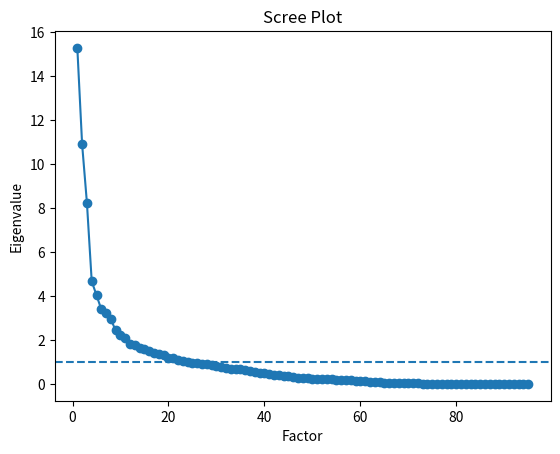

In [15]:
# ==== 스크리 플롯 전용: 요인 수 가늠 ==== ** 카테고리 값은 EFA에 넣어봤자 의미 없으니 제외, 결측치 0으로 채울 시 전부 없어서 평균이 0인 경우의 열도 제외, 셋 중 하나만 살릴 것 **
                                                                                    # 결측치를 전부 제거한 경우에도 일단은 돌려둠 : 어차피 분산이 0인 경우도 제외해야 하므로


# ==== 수면기회 (Opportunity) ====

# fa_vars = [c for c in [
# "MCTQ_BTw_c",    # 근무날 침대로 들어가는 시각
# "MCTQ_BTf_c",    # 쉬는날 침대로 들어가는 시각
# "MCTQ_BTa_c",    # 평균 침대로 들어가는 시각
# "MCTQ_GUw",    # 근무날 침대에서 나오는 시각
# "MCTQ_GUf",    # 쉬는날 침대에서 나오는 시각
# "MCTQ_GUa",    # 평균 침대에서 나오는 시각
# "MCTQ_MBW",    # 근무날 침대에 있는 시각 중간점
# "MCTQ_MBF",    # 쉬는날 침대에 있는 시각 중간점
# "MCTQ_Sprepw_c",    # 근무날 잠 잘 준비가 된 시각
# "MCTQ_Sprepf_c",    # 쉬는날 잠 잘 준비가 된 시각
# "MCTQ_Sprepa_c",    # 평균 잠 잘 준비가 된 시간
# "MCTQ_TBTw_c",    # 근무날 침대에 있는 시간
# "MCTQ_TBTf_c",    # 쉬는날 침대에 있는 시간
# "MCTQ_TBTa_c",    # 평균 침대에 있는 시간
# "MCTQ_TFSw",    # 근무날 수면을 위한 시간
# "MCTQ_TFSf",    # 쉬는날 수면을 위한 시간
# "MCTQ_TFSa",    # 평균 수면을 위한 시간
# "MCTQ_TFPw",    # 근무날 취침 전 지연행동 시간
# "MCTQ_TFPf",    # 쉬는날 취침 전 지연행동 시간
# "MCTQ_TFPa",    # 평균 취침 전 지연행동 시간
# "Q64_SIw",    # 근무날 기상 후 지연행동 시간
# "Q74_SIf",    # 쉬는날 기상 후 지연행동 시간
# "MCTQ_SIa",    # 평균 기상 후 지연행동 시간
# "MCTQ_SJL_bed",    # 근무날/쉬는날 침대에 있는 시간 중간점 차이
# "MCTQ_bed_reg",    # 근무날/쉬는날 침대에 있는 시간의 상대적 차이
# ] if c in df.columns]



# ==== 수면능력 (Ability) ====

# fa_vars = [c for c in [
# "MCTQ_SDw_c",    # 근무날 수면시간
# "MCTQ_SDf_c",    # 쉬는날 수면시간
# "MCTQ_SDa_c",    # 평균 수면시간
# "Q62_SLatw",    # 근무날 수면잠복기
# "Q72_SLatf",    # 쉬는날 수면잠복기
# "MCTQ_Slata",    # 평균 수면잠복기
# "MCTQ_SE_w_c",    # 근무날 수면효율
# "MCTQ_SE_f_c",    # 쉬는날 수면효율
# "MCTQ_SE_a_c",    # 평균 수면효율
# "MCTQ_SOw_c",    # 근무날 잠드는 시각
# "MCTQ_SOf_c",    # 쉬는날 잠드는 시각
# "MCTQ_SOa_c",    # 평균 잠드는 시각
# "MCTQ_SEw",    # 근무날 잠에서 깬 시각
# "MCTQ_SEf",    # 쉬는날 잠에서 깬 시각
# "MCTQ_SEa",    # 평균 잠에서 깬 시각
# "MCTQ_MSW",    # 근무날 수면시각 중간점
# "MCTQ_MSF",    # 쉬는날 수면시각 중간점
# "MCTQ_SJL",    # 근무날/쉬는날 수면시간 중간점 차이
# "MCTQ_sleep_reg",    # 근무날/쉬는날 수면시간의 상대적 차이
# "ISI_sum",    # 불면증 심각도 척도 (ISI)
# "PSQI_sum_WA",    # 피처버그 수면의 질 지수 (PSQI)
# ] if c in df.columns]



# ==== 수면필요 (Need) ====

# fa_vars = [c for c in [
# "Q51_slp_sufficient",    # 야간수면 충분도
# "Q91_ISI_4",    # 수면양상 만족도
# "MCTQ_CUS",    # 주말 수면 보충 시간
# "desired_sd_min",    # 충분하다고 생각하는 수면 시간
# "Pristine_SD",    # Pristine 평가 수면시간
# "SD_mismatch_desired",    # 충분수면시간과 실제 차이
# "SD_mismatch_pristine",    # Pristine 평가 수면시간과 실제 차이
# "nap_n",    # 낮잠횟수
# "Q48_nap_dur",    # 낮잠시간
# "ESS_sum",    # 앱워스 졸음척도 (ESS)
# "inertia",    # 수면관성 (기상 후 머리가 맑아질때까지 시간)
# "FSS_sum",    # 피로 증상 척도 (FSS)
# "Pristine_SO_c",    # Pristine 평가 잠드는 시각
# "Pristine_SE",    # Pristine 평가 잠에서 깬 시각
# "Pristine_MS",    # Pristine 평가 수면시각 중간점
# "SO_mismatch_pristine",    # Pristine 평가 잠드는 시각과 실제 차이
# "SE_mismatch_pristine",    # Pristine 평가 잠에서 깬 시각과 실제 차이
# "MSW_mismatch_pristine",    # Pristine 평가 수면시각 중간점과 실제 차이
# "MSF_mismatch_pristine",    # Pristine 평가 잠드는 시각과 실제 잠드는 시각 차이
# "MCTQ_MSFsc",    # 일주기유형
# ] if c in df.columns]


# # ==== 전체 값 (Ver 2에선 카테고리 값도 그냥 EFA 분석에 추가하기, 대신 EFA용 부분 데이터셋만 사용) ====
fa_vars = df_EFA.columns.tolist() # 데이터프레임이 아니라 변수명이 들어가야 함



if len(fa_vars) < 3:
    raise ValueError(f"[skip] 요인분석 변수 수 부족: {fa_vars}")

# --- 정제 단계 ---
X = df_EFA[fa_vars].copy()
X = X.apply(pd.to_numeric, errors='coerce')
X = X.replace([np.inf, -np.inf], np.nan)

# 1) 전부 결측 열 확인
all_nan_cols = X.columns[X.isna().all()]
if len(all_nan_cols) > 0:
    print("[제거] 전부 결측인 열:", list(all_nan_cols))
X = X.drop(columns=all_nan_cols)

# 2) 중앙값 대치
imp = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)

# 3) 분산 0(또는 극소) 열 확인
stds = X_imp.std(ddof=0)
zero_var_cols = stds[stds <= 1e-5].index
if len(zero_var_cols) > 0:
    print("[제거] 분산≈0인 열:", list(zero_var_cols))
X_imp = X_imp.drop(columns=zero_var_cols)

# 4) 상관행렬 NaN 발생 여부 점검
corr = X_imp.corr()
bad_in_corr = corr.columns[corr.isna().any()].tolist()
if len(bad_in_corr) > 0:
    print("[경고] 상관행렬에서 NaN 발생한 열:", bad_in_corr)

# 5) 변수 수 최종 확인
if X_imp.shape[1] < 3:
    raise ValueError(f"[중단] 정제 후 변수 수 부족: {list(X_imp.columns)}")

# --- 스크리 플롯 ---
fa_scree = FactorAnalyzer(rotation='oblimin')
fa_scree.fit(X_imp)

eigenvals, _ = fa_scree.get_eigenvalues()
print("[EFA] 고유값(Eigenvalues):", np.round(eigenvals[:X_imp.shape[1]], 4))

plt.figure()
plt.plot(range(1, len(eigenvals) + 1), eigenvals, marker='o')
plt.axhline(1, linestyle='--')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()


                       Factor1  Factor2  Factor3  Factor4  Factor5
SW                      -0.025   -0.008   -0.025   -0.080   -0.038
sex                      0.019    0.075    0.126   -0.181    0.052
age                      0.382   -0.103   -0.017   -0.245    0.354
Q59_1_w                  0.045   -0.094   -0.030    0.085   -0.150
Q59_1_f                 -0.045    0.094    0.030   -0.085    0.150
D3_1_ht                 -0.122   -0.005   -0.089    0.257   -0.146
D3_2_wt                 -0.002   -0.017   -0.097    0.180    0.003
BMI                      0.102   -0.023   -0.063    0.037    0.131
D4_edu                  -0.283    0.085    0.027    0.264   -0.303
D5_income               -0.183    0.099    0.104    0.204   -0.278
Q56_alc                  0.056    0.024    0.074   -0.219    0.124
Q57_smok                 0.004    0.081    0.069   -0.225    0.015
Q58_exercise            -0.059    0.022   -0.043   -0.016    0.038
MCTQ_BTw_c               0.855    0.296    0.176    0.036   -0

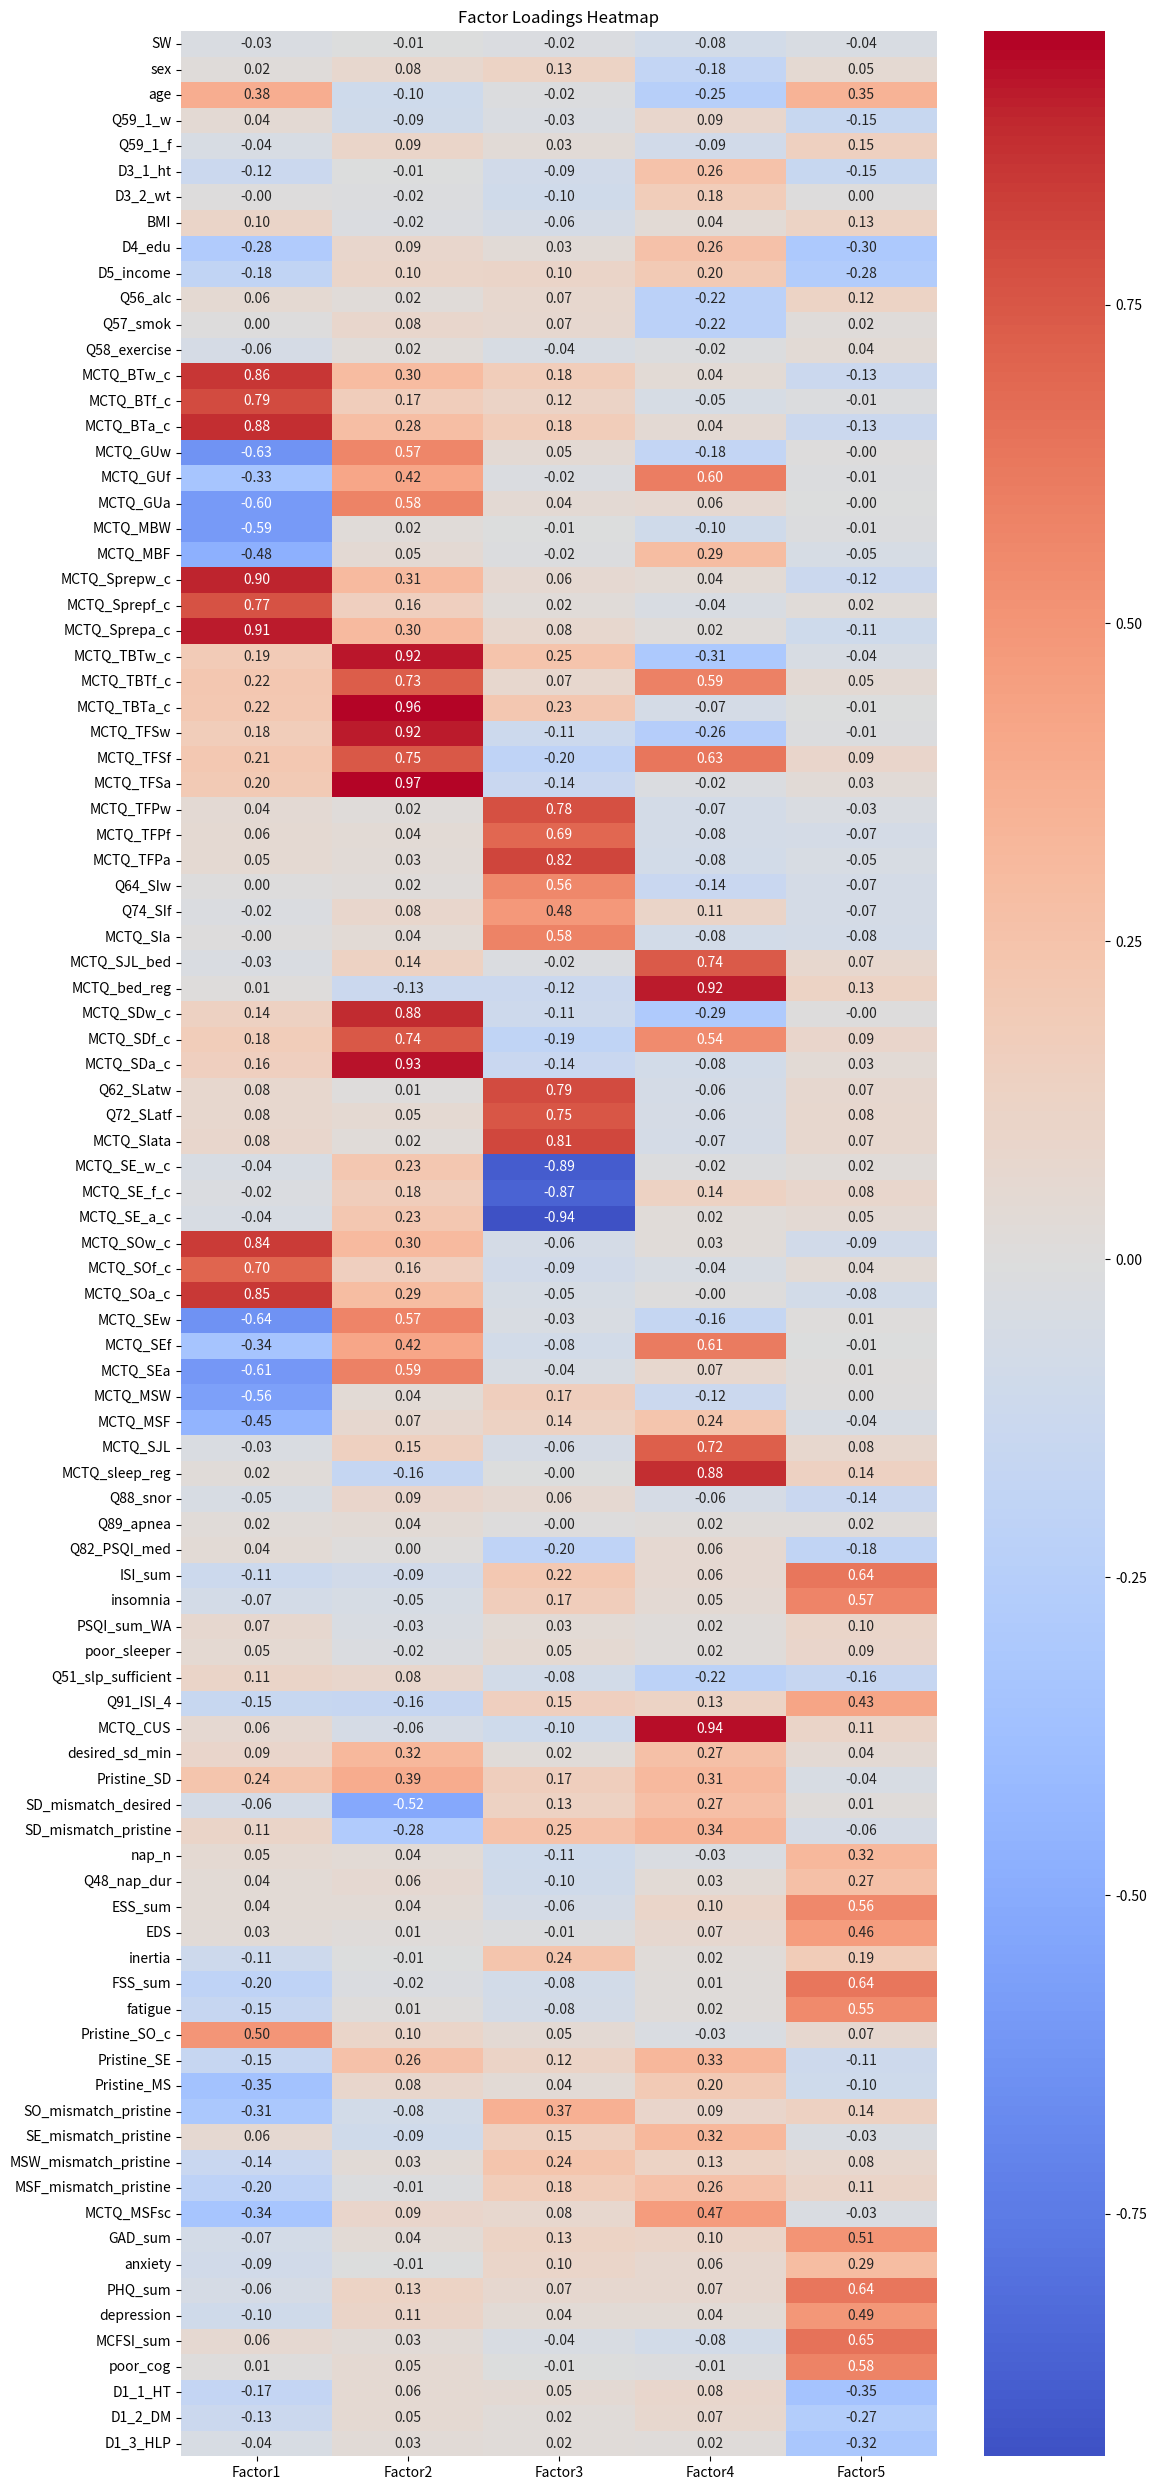

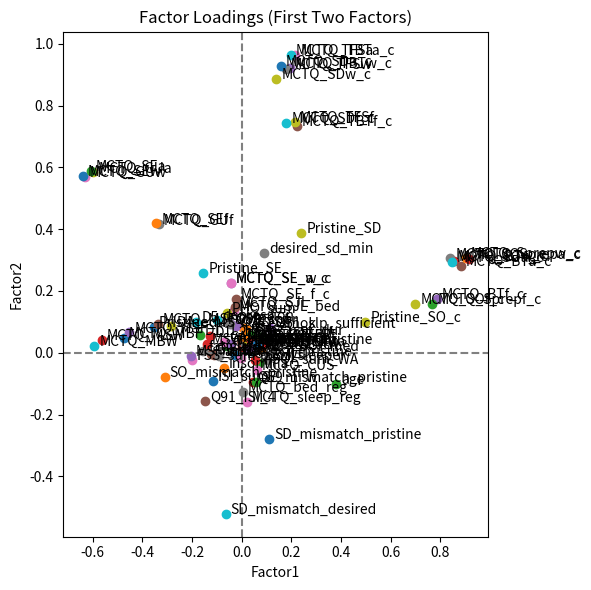

In [16]:
# EFA 시작, 저 밑에 N_FACTORS 설정 후 실행!!!!!

def preprocess_for_fa(df, fa_vars, min_var=1e-12):
    """EFA용 전처리: 숫자화→Inf/NaN 처리→전부 결측 열 제거→중앙값 대치→분산≈0 열 제거"""
    X = df[fa_vars].copy()
    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.replace([np.inf, -np.inf], np.nan)

    # 전부 결측 열 제거
    all_nan_cols = X.columns[X.isna().all()]
    if len(all_nan_cols) > 0:
        X = X.drop(columns=all_nan_cols)

    # 중앙값 대치
    imp = SimpleImputer(strategy='median')
    X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)

    # 분산≈0 열 제거
    stds = X_imp.std(ddof=0)
    keep = stds > min_var
    X_imp = X_imp.loc[:, keep]

    # 남은 열이 최소 3개 미만이면 EFA 불가
    if X_imp.shape[1] < 3:
        raise ValueError(f"[중단] 정제 후 변수 수 부족: {list(X_imp.columns)}")

    return X_imp

# ==== 사용자가 선택한 요인 수 ====
N_FACTORS = 5  # <- 스크리 플롯 보고 결정

# fa_vars 는 기존과 동일하게 정의되어 있다고 가정
X_imp = preprocess_for_fa(df_EFA, fa_vars)   # ✅ 스크리플롯과 동일 전처리 적용

# (선택) 표준화: 스케일 차이가 크면 권장
# X_imp = (X_imp - X_imp.mean()) / X_imp.std(ddof=0)

# N_FACTORS 검증: 변수 수를 넘을 수 없음
max_factors = min(X_imp.shape[1]-1, X_imp.shape[0]-1)  # 보수적으로 제한
if N_FACTORS > max_factors:
    raise ValueError(f"N_FACTORS={N_FACTORS}가 허용치({max_factors})를 초과")

# 1-요인일 때 varimax 회전은 의미가 거의 없음(keep 그대로 사용해도 무방)
fa = FactorAnalyzer(n_factors=N_FACTORS, rotation="promax")
fa.fit(X_imp)

# 적재치 행렬
cols = [f"Factor{i+1}" for i in range(N_FACTORS)]
loadings = pd.DataFrame(fa.loadings_, index=X_imp.columns, columns=cols)
print(loadings.round(3).to_string())
loadings.round(3).to_csv("factor_loadings.csv", index=True, encoding="utf-8-sig") # 파일 저장

# # ---- Heatmap (축 개수 제한 없음) ----
# plt.figure(figsize=(1.5*N_FACTORS+4, 0.4*len(loadings)+3))
# sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0, fmt=".2f")
# plt.title("Factor Loadings Heatmap")
# plt.tight_layout()
# plt.show()


# ---- Heatmap (축 개수 제한 없음, 단 변수 많으면 단순화) ----
MAX_ANNOT_VARS = 4000  # 이 값 넘으면 숫자 제거 + 크기 간소화     ===>>> 일단 여기선 전체 경향을 봐야 하므로 그냥 다 표시

n_vars = len(loadings)
annot_flag = n_vars <= MAX_ANNOT_VARS

fig_height = min(0.4 * n_vars + 3, 25)  # 세로축 최대 크기 제한 (예: 25인치)

plt.figure(figsize=(1.5*N_FACTORS+4, fig_height))
sns.heatmap(
    loadings,
    annot=annot_flag,
    cmap="coolwarm",
    center=0,
    fmt=".2f" if annot_flag else "",
    cbar=True
)
plt.title("Factor Loadings Heatmap" + ("" if annot_flag else " (values hidden)"))
plt.tight_layout()
plt.show()



# ---- Loading Scatter: 앞 두 축만 ----
if N_FACTORS >= 2:
    plt.figure(figsize=(6,6))
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    for var in loadings.index:
        x, y = loadings.loc[var, "Factor1"], loadings.loc[var, "Factor2"]
        plt.scatter(x, y)
        plt.text(x + 0.02, y, var)
    plt.xlabel("Factor1")
    plt.ylabel("Factor2")
    plt.title("Factor Loadings (First Two Factors)")
    plt.tight_layout()
    plt.show()
else:
    print("[info] N_FACTORS=1: 산점도(2D) 생략")

In [17]:
# 공통성 / 특이성 계산
communalities = pd.Series(fa.get_communalities(), index=X_imp.columns, name="Communality")
uniqueness    = pd.Series(fa.get_uniquenesses(), index=X_imp.columns, name="Uniqueness")

result = pd.concat([communalities, uniqueness], axis=1).round(3)
print(result.to_string())
result.to_csv("communality.csv", index=True, encoding="utf-8-sig") # 파일 저장


                       Communality  Uniqueness
SW                           0.009       0.991
sex                          0.057       0.943
age                          0.342       0.658
Q59_1_w                      0.042       0.958
Q59_1_f                      0.042       0.958
D3_1_ht                      0.110       0.890
D3_2_wt                      0.042       0.958
BMI                          0.034       0.966
D4_edu                       0.249       0.751
D5_income                    0.173       0.827
Q56_alc                      0.072       0.928
Q57_smok                     0.062       0.938
Q58_exercise                 0.008       0.992
MCTQ_BTw_c                   0.868       0.132
MCTQ_BTf_c                   0.667       0.333
MCTQ_BTa_c                   0.909       0.091
MCTQ_GUw                     0.756       0.244
MCTQ_GUf                     0.650       0.350
MCTQ_GUa                     0.702       0.298
MCTQ_MBW                     0.362       0.638
MCTQ_MBF     

# Ver 2 추가 : CFA를 위한 요인구조 정제 전처리
- 공통성이 특정 값 이하인 변수 제거 (기본 : 0.2)
- 가장 높은 적재량(절대값)이 특정 값 이하인 변수 제거 (기본 : 0.35)
- 적재량이 가장 높은 요인으로 구조화

In [18]:
def refine_for_cfa(
    result,
    loadings,
    n_factors,
    communality_thr=0.2,
    loading_thr=0.35,
    overlap_mode="single"  # "remove", "single", "multi"
):
    """
    EFA 결과를 기반으로 CFA 요인구조를 정제하는 함수.
    
    Parameters
    ----------
    result : pd.DataFrame
        EFA 결과 (Communality 열 포함)
    loadings : pd.DataFrame
        요인적재량 DataFrame
    n_factors : int
        요인 개수
    communality_thr : float
        공통성 기준
    loading_thr : float
        적재량 기준
    overlap_mode : str
        중복 허용 모드 ("remove" | "single" | "multi")
        - "remove": 중복 발생 시 변수 제거
        - "single": 가장 높은 요인에만 배정 (기본값)
        - "multi": 중복 요인 모두 포함
    """
    df_comm = result.copy()
    df_load = loadings.copy()

    # 1️⃣ 공통성 기준
    drop_comm = df_comm[df_comm["Communality"] <= communality_thr].index.tolist()

    # 2️⃣ 최대 적재량 기준
    abs_load = df_load.abs()
    max_load = abs_load.max(axis=1)
    drop_low = max_load[max_load <= loading_thr].index.tolist()

    # 3️⃣ 제거 대상 합치기
    drop_vars = sorted(set(drop_comm + drop_low))
    print(f"[제거] 공통성≤{communality_thr} 또는 최대적재량≤{loading_thr} 변수 {len(drop_vars)}개:")
    print(drop_vars, "\n")

    # 4️⃣ 필터링 후 데이터프레임
    keep_vars = [v for v in df_load.index if v not in drop_vars]
    df_load_filtered = df_load.loc[keep_vars]
    abs_load = abs_load.loc[keep_vars]

    # 5️⃣ 요인별 변수 구조화
    factor_map = {f"Factor{i}": [] for i in range(1, n_factors + 1)}

    for var in keep_vars:
        strong_factors = abs_load.columns[abs_load.loc[var] >= loading_thr].tolist()

        if len(strong_factors) == 0:
            continue

        if overlap_mode == "remove":
            # 중복이면 완전히 제거
            if len(strong_factors) > 1:
                continue
            else:
                factor_map[strong_factors[0]].append(var)

        elif overlap_mode == "single":
            # 가장 높은 하나만 선택
            top_factor = abs_load.loc[var].idxmax()
            factor_map[top_factor].append(var)

        elif overlap_mode == "multi":
            # 중복 모두 허용
            for f in strong_factors:
                factor_map[f].append(var)

        else:
            raise ValueError("overlap_mode는 'remove', 'single', 'multi' 중 하나여야 합니다.")

    # 6️⃣ 요인별 변수 구조 출력
    print(f"✅ 요인별 변수 구조 (중복 모드: {overlap_mode})")
    for fname, members in factor_map.items():
        print(f" - {fname} ({len(members)}개): {members}")


    # 7️⃣ 가로형 CSV 저장
    # 요인 이름 순서 보장
    factor_names = [f"Factor{i}" for i in range(1, n_factors + 1)]
    factor_lists = [factor_map[f] for f in factor_names]

    # zip_longest로 각 요인 열 길이를 맞추기
    df_factors_wide = pd.DataFrame(
        zip_longest(*factor_lists),
        columns=factor_names
    )

    # CSV 저장
    df_factors_wide.to_csv("factor_assignment_wide.csv", index=False, encoding="utf-8-sig")
    print("💾 'factor_assignment_wide.csv' (가로형) 파일로 저장 완료.")



    return {
        "loadings_filtered": df_load_filtered,
        "drop_vars": drop_vars,
        "factor_groups": factor_map
    }

cfa_refined = refine_for_cfa(
    result=result,
    loadings=loadings,
    n_factors=N_FACTORS, # 4
    communality_thr=0.3,
    loading_thr=0.40,
    overlap_mode="remove"  # "remove", "single", "multi" 중 선택
)

[제거] 공통성≤0.3 또는 최대적재량≤0.4 변수 42개:
['BMI', 'D1_1_HT', 'D1_2_DM', 'D1_3_HLP', 'D3_1_ht', 'D3_2_wt', 'D4_edu', 'D5_income', 'EDS', 'GAD_sum', 'MCTQ_MSF', 'MSF_mismatch_pristine', 'MSW_mismatch_pristine', 'PSQI_sum_WA', 'Pristine_MS', 'Pristine_SD', 'Pristine_SE', 'Pristine_SO_c', 'Q48_nap_dur', 'Q51_slp_sufficient', 'Q56_alc', 'Q57_smok', 'Q58_exercise', 'Q59_1_f', 'Q59_1_w', 'Q74_SIf', 'Q82_PSQI_med', 'Q88_snor', 'Q89_apnea', 'Q91_ISI_4', 'SD_mismatch_pristine', 'SE_mismatch_pristine', 'SO_mismatch_pristine', 'SW', 'age', 'anxiety', 'depression', 'desired_sd_min', 'inertia', 'nap_n', 'poor_sleeper', 'sex'] 

✅ 요인별 변수 구조 (중복 모드: remove)
 - Factor1 (12개): ['MCTQ_BTw_c', 'MCTQ_BTf_c', 'MCTQ_BTa_c', 'MCTQ_MBW', 'MCTQ_MBF', 'MCTQ_Sprepw_c', 'MCTQ_Sprepf_c', 'MCTQ_Sprepa_c', 'MCTQ_SOw_c', 'MCTQ_SOf_c', 'MCTQ_SOa_c', 'MCTQ_MSW']
 - Factor2 (7개): ['MCTQ_TBTw_c', 'MCTQ_TBTa_c', 'MCTQ_TFSw', 'MCTQ_TFSa', 'MCTQ_SDw_c', 'MCTQ_SDa_c', 'SD_mismatch_desired']
 - Factor3 (11개): ['MCTQ_TFPw', 'MCTQ_TFPf'

In [19]:
# ----------------------------------------
# CFA 구조식(desc) 자동 생성 (+ 요인분산=1 고정 포함)
# ----------------------------------------
def make_cfa_description(factor_map):
    """
    factor_map: {'Factor1': ['a','b'], 'Factor2': ['c','d']} 형태
    반환: lavaan-style formula string
    """
    lines = []
    
    # (1) 요인 적재식 생성
    for factor, vars_ in factor_map.items():
        if len(vars_) == 0:
            continue
        joined = " + ".join(vars_)
        line = f"{factor} =~ {joined}"
        lines.append(line)
    
    # (2) 요인분산=1 고정 구문 자동 추가
    for factor in factor_map.keys():
        lines.append(f"{factor} ~~ 1*{factor}")
    
    # (3) 하나의 문자열로 결합
    desc = "\n".join(lines)
    
    # (4) 결과 확인용 출력
    print("✅ CFA용 요인구조(desc):\n")
    print(desc)
    
    return desc


# ----------------------------------------
# 실행 예시
# ----------------------------------------
desc = make_cfa_description(cfa_refined["factor_groups"])


✅ CFA용 요인구조(desc):

Factor1 =~ MCTQ_BTw_c + MCTQ_BTf_c + MCTQ_BTa_c + MCTQ_MBW + MCTQ_MBF + MCTQ_Sprepw_c + MCTQ_Sprepf_c + MCTQ_Sprepa_c + MCTQ_SOw_c + MCTQ_SOf_c + MCTQ_SOa_c + MCTQ_MSW
Factor2 =~ MCTQ_TBTw_c + MCTQ_TBTa_c + MCTQ_TFSw + MCTQ_TFSa + MCTQ_SDw_c + MCTQ_SDa_c + SD_mismatch_desired
Factor3 =~ MCTQ_TFPw + MCTQ_TFPf + MCTQ_TFPa + Q64_SIw + MCTQ_SIa + Q62_SLatw + Q72_SLatf + MCTQ_Slata + MCTQ_SE_w_c + MCTQ_SE_f_c + MCTQ_SE_a_c
Factor4 =~ MCTQ_SJL_bed + MCTQ_bed_reg + MCTQ_SJL + MCTQ_sleep_reg + MCTQ_CUS + MCTQ_MSFsc
Factor5 =~ ISI_sum + insomnia + ESS_sum + FSS_sum + fatigue + PHQ_sum + MCFSI_sum + poor_cog
Factor1 ~~ 1*Factor1
Factor2 ~~ 1*Factor2
Factor3 ~~ 1*Factor3
Factor4 ~~ 1*Factor4
Factor5 ~~ 1*Factor5


In [20]:
# # 사용자 지정 변수 선정

# desc = """
# Factor1 =~ MCTQ_BTa_c + MCTQ_MBW + MCTQ_MBF + MCTQ_Sprepa_c
# Factor2 =~ MCTQ_TBTa_c + MCTQ_TFSa + SD_mismatch_desired
# Factor3 =~ MCTQ_TFPa + MCTQ_SIa + MCTQ_Slata + MCTQ_SE_a_c + SO_mismatch_pristine + MCTQ_SDa_c
# Factor4 =~ MCTQ_SJL_bed + MCTQ_bed_reg + MCTQ_SJL + MCTQ_sleep_reg + MCTQ_CUS
# Factor5 =~ ISI_sum + Q91_ISI_4 + FSS_sum + GAD_sum + PHQ_sum + MCFSI_sum
# Factor1 ~~ 1*Factor1
# Factor2 ~~ 1*Factor2
# Factor3 ~~ 1*Factor3
# Factor4 ~~ 1*Factor4
# Factor5 ~~ 1*Factor5
# """

In [21]:
# 사용자 지정 변수 선정 2 : CFA 분석 결과에 따라 제외 가능한 변수 제외한 버전
desc = """
Factor1 =~ MCTQ_BTa_c + MCTQ_MBW + MCTQ_MBF + MCTQ_Sprepa_c
Factor2 =~ MCTQ_TBTa_c + MCTQ_TFSa + SD_mismatch_desired
Factor3 =~ MCTQ_TFPa + MCTQ_Slata + MCTQ_SE_a_c + SO_mismatch_pristine + MCTQ_SDa_c
Factor4 =~ MCTQ_SJL + MCTQ_sleep_reg + MCTQ_CUS
Factor5 =~ ISI_sum + Q91_ISI_4 + FSS_sum + GAD_sum + PHQ_sum + MCFSI_sum
Factor1 ~~ 1*Factor1
Factor2 ~~ 1*Factor2
Factor3 ~~ 1*Factor3
Factor4 ~~ 1*Factor4
Factor5 ~~ 1*Factor5
"""

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;
&nbsp;
&nbsp;
# CFA 및 카이제곱 진행

In [22]:
from semopy import Model, calc_stats
import pandas as pd

# 이 코드를 실행하기 전에 df_CFA (데이터프레임)와 desc (모델 구조 문자열)가
# 메모리에 로드되어 있어야 합니다.

# --- CFA 모델링 ---

# 1. 모델 정의
# desc 변수는 이전 단계에서 make_cfa_description 함수로 생성했다고 가정합니다.
# 예시: desc = "Factor1 =~ Var1 + Var2\nFactor2 =~ Var3 + Var4"
model = Model(desc)

# 2. 모델 학습 (핵심 수정 부분)
# options={'disp': True}를 추가하여 최적화 과정의 상세 정보를 출력합니다.
# 각 반복(iteration)마다 현재 상태, 함수 값 등의 정보가 화면에 나타납니다.
print("--- CFA 모델 최적화를 시작합니다 (진행 상황 출력) ---")
model.fit(df_CFA, options={'disp': True})
print("--- CFA 모델 최적화가 완료되었습니다 ---\n")

# 3. 요인 부하량, 적합도 지표 확인 (기존과 동일)
print("--- 모델 분석 결과 ---")
est = model.inspect()
print(est)
# 결과를 파일로 저장
try:
    est.to_csv("cfa_estimates.csv", index=False, encoding="utf-8-sig")
    print("\n'cfa_estimates.csv' 파일로 결과가 저장되었습니다.")
except Exception as e:
    print(f"\n파일 저장 중 오류 발생: {e}")


print("\n--- 모델 적합도 지표 ---")
stats = calc_stats(model)
print(stats)
# 결과를 파일로 저장
try:
    stats.to_csv("cfa_fit_stats.csv", index=False, encoding="utf-8-sig")
    print("\n'cfa_fit_stats.csv' 파일로 결과가 저장되었습니다.")
except Exception as e:
    print(f"\n파일 저장 중 오류 발생: {e}")



--- CFA 모델 최적화를 시작합니다 (진행 상황 출력) ---
Optimization terminated successfully    (Exit mode 0)
            Current function value: 40.0201324503454
            Iterations: 34
            Function evaluations: 60
            Gradient evaluations: 34
--- CFA 모델 최적화가 완료되었습니다 ---

--- 모델 분석 결과 ---
                    lval  op                  rval      Estimate  Std. Err  \
0             MCTQ_BTa_c   ~               Factor1  1.000000e+00         -   
1               MCTQ_MBW   ~               Factor1 -5.514698e-01  0.024213   
2               MCTQ_MBF   ~               Factor1 -5.517772e-01  0.024826   
3          MCTQ_Sprepa_c   ~               Factor1  9.740150e-01  0.022209   
4            MCTQ_TBTa_c   ~               Factor2  1.000000e+00         -   
5              MCTQ_TFSa   ~               Factor2  1.065944e+00  0.015445   
6    SD_mismatch_desired   ~               Factor2 -5.623177e-01  0.024986   
7              MCTQ_TFPa   ~               Factor3  1.000000e+00         -   
8      

In [23]:
# # EFA 결과를 바탕으로 CFA 모델링 (단, 별도의 데이터셋이 필요하므로 코드를 돌리긴 했지만 유의한 지표는 아님)

# from semopy import Model
# import pandas as pd

# # CFA 모델 정의 (lavaan-style syntax) -> EFA 결과에 맞게 임의로 판단 -> 위에서 자동으로 진행했음
# # desc = """
# # Factor1 =~ GAD_sum + PHQ_sum
# # Factor2 =~ ISI_sum + ESS_sum + FSS_sum
# # """

# model = Model(desc)
# model.fit(df_CFA)  # CFA에 사용할 데이터셋 (관찰변수들 포함된 DataFrame)

# # 요인 부하량, 적합도 지표 확인
# est = model.inspect()
# print(est)
# est.to_csv("cfa_estimates.csv", index=False, encoding="utf-8-sig") # 파일 저장

# from semopy import calc_stats
# stats = calc_stats(model)
# print(stats)
# stats.to_csv("cfa_fit_stats.csv", index=False, encoding="utf-8-sig") # 파일 저장


# 시각화

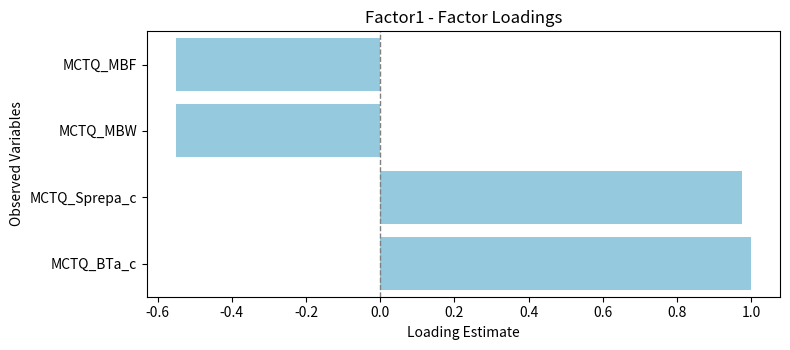

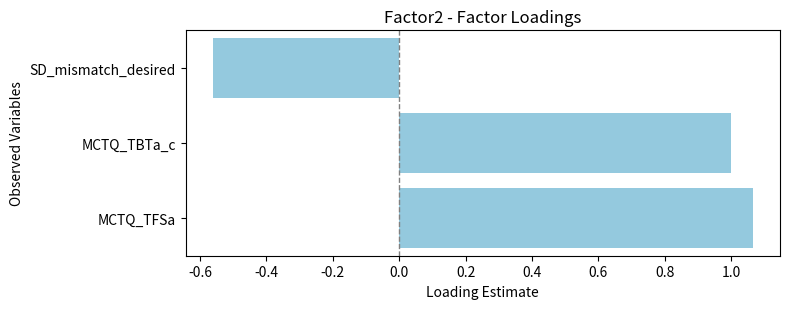

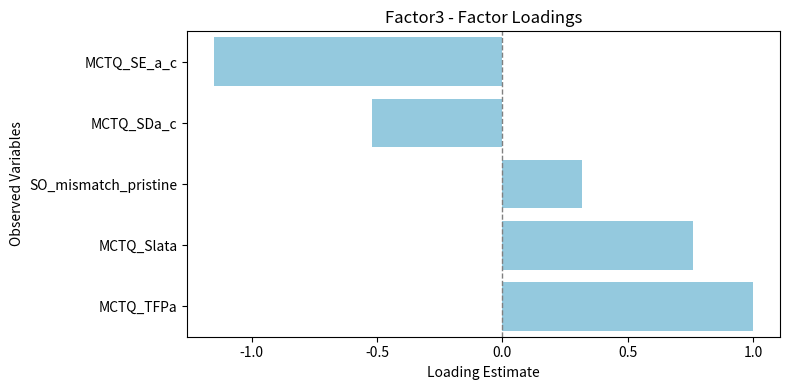

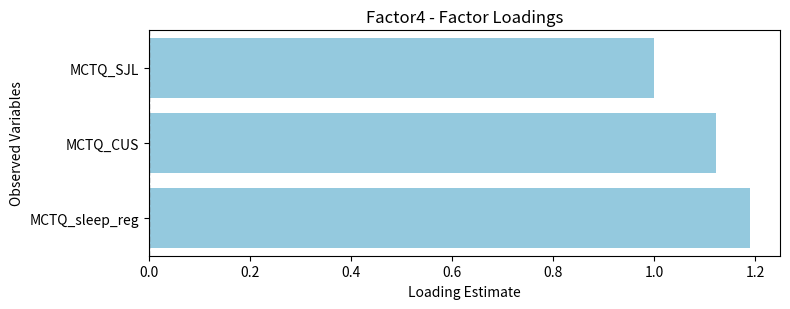

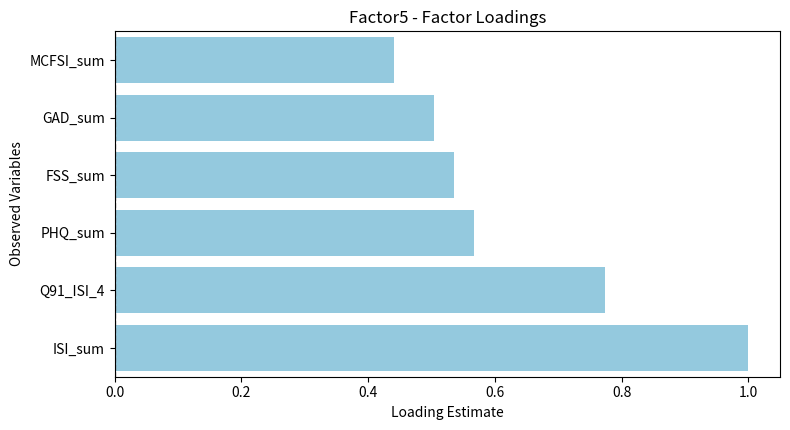

In [24]:
def plot_cfa_loadings_by_factor(est, save_figs=False, out_dir="./", use_std=True):
    """
    CFA 요인적재량을 요인별로 개별 시각화하는 함수.
    
    Parameters
    ----------
    est : pd.DataFrame
        semopy의 model.inspect() 결과 (lval, op, rval, Estimate 등 포함)
    save_figs : bool
        True면 각 요인별 그래프를 개별 PNG로 저장
    out_dir : str
        저장 경로 (save_figs=True일 때만 사용)
    use_std : bool
        True면 'Std.Estimate' 열 사용, 없으면 Estimate 사용
    """
    # 1️⃣ 요인적재량(=~)만 필터링
    df_load = est[est["op"] == "~"].copy()

    # 2️⃣ 컬럼 매핑 (semopy 구조에 맞게)
    # lval = 관찰변수, rval = 요인
    df_load = df_load.rename(columns={"lval": "Variable", "rval": "Factor"})

    # 3️⃣ 사용할 적재량 열 선택
    if use_std:
        std_cols = [c for c in df_load.columns if "std" in c.lower() and "est" in c.lower()]
        loading_col = std_cols[0] if std_cols else "Estimate"
    else:
        loading_col = "Estimate"

    # 4️⃣ 요인 목록 순회하며 개별 그래프 생성
    factors = sorted(df_load["Factor"].unique())
    for factor in factors:
        subset = df_load[df_load["Factor"] == factor].copy()
        subset = subset.sort_values(by=loading_col, ascending=True)

        plt.figure(figsize=(8, 0.4 * len(subset) + 2))
        sns.barplot(
            data=subset,
            y="Variable",
            x=loading_col,
            color="skyblue",
            orient="h"
        )
        plt.axvline(0, color='gray', linestyle='--', lw=1)
        plt.title(f"{factor} - Factor Loadings")
        plt.xlabel("Standardized Loading" if "std" in loading_col.lower() else "Loading Estimate")
        plt.ylabel("Observed Variables")
        plt.tight_layout()

        # 저장 여부
        if save_figs:
            filename = f"{out_dir.rstrip('/')}/{factor}_loadings.png"
            plt.savefig(filename, dpi=150, bbox_inches="tight")
            print(f"💾 {filename} 저장 완료")
        else:
            plt.show()

# ✅ 사용 예시
plot_cfa_loadings_by_factor(est, save_figs=False)

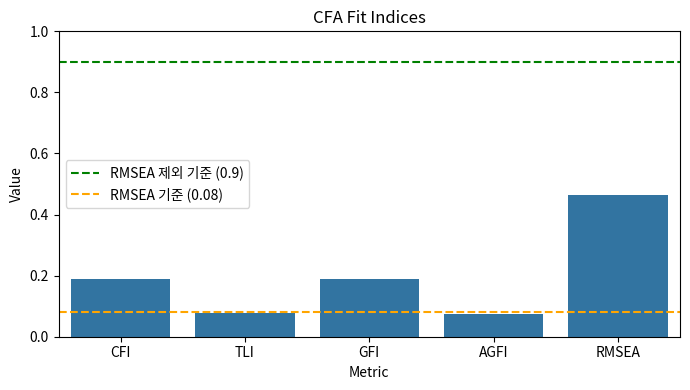

In [25]:
# 주요 적합도 지표만 추출
fit_indices = stats.loc["Value", ["CFI", "TLI", "GFI", "AGFI", "RMSEA"]]
fit_indices = fit_indices.reset_index()
fit_indices.columns = ["Metric", "Value"]

plt.figure(figsize=(7,4))
sns.barplot(data=fit_indices, x="Metric", y="Value")
plt.axhline(0.9, color="green", linestyle="--", label="RMSEA 제외 기준 (0.9)")
plt.axhline(0.08, color="orange", linestyle="--", label="RMSEA 기준 (0.08)")
plt.title("CFA Fit Indices")
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()
